In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(40, 10))

from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import LocalOutlierFactor

from imblearn.over_sampling import SMOTE

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import lightgbm as lgbm

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, RepeatedKFold, GridSearchCV

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import accuracy_score, log_loss, make_scorer, roc_auc_score

import optuna
from optuna.integration import LightGBMPruningCallback
import optuna.integration.lightgbm as lbgm
import catboost as cb
import xgboost as xgb

<Figure size 2880x720 with 0 Axes>

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

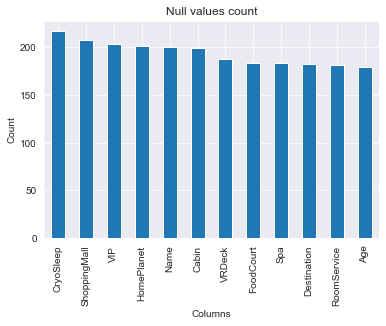

In [3]:
null_count = train_df.isna().sum().sort_values(ascending=False)

plt.title('Null values count')
plt.xlabel('Columns')
plt.ylabel('Count')
null_count[null_count > 0].plot(kind='bar');

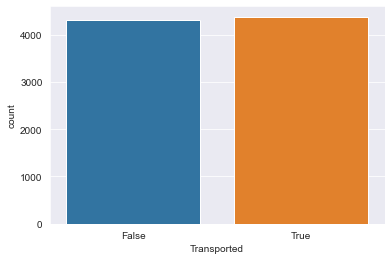

In [4]:
sns.countplot(x = train_df['Transported'].values).set_xlabel('Transported');

In [5]:
size_train_df = train_df.shape[0]
size_test_df = test_df.shape[0]
y_train = train_df['Transported'].values
test_IDs = test_df['PassengerId'].values
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['Transported', 'PassengerId', 'Name'], axis=1, inplace=True)
all_data.shape

(12970, 11)

<h4>Feature Engeneering</h4>

In [6]:
all_data['Cabin_split'] = all_data['Cabin'].apply(lambda x: str(x).split(sep='/'))

In [7]:
all_data['Cabin_0'] = all_data['Cabin_split'].apply(lambda x: np.nan if x[0] == 'nan' else x[0])
all_data['Cabin_1'] = all_data['Cabin_split'].apply(lambda x: np.nan if x[0] == 'nan' else x[1])
all_data['Cabin_2'] = all_data['Cabin_split'].apply(lambda x: np.nan if x[0] == 'nan' else x[2])

In [8]:
all_data.drop(['Cabin', 'Cabin_split'], axis=1, inplace=True)

In [9]:
categorical_col = []
for col in all_data.columns:
    if all_data[col].dtype in [object, bool] and len(all_data[col].unique()) <= 50:
        categorical_col.append(col)

In [10]:
for col in categorical_col:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [11]:
all_data['Age'] = all_data['Age'].fillna(all_data['Age'].mode()[0])
all_data['Cabin_1'] = all_data['Cabin_1'].fillna(all_data['Cabin_1'].mode()[0])

In [12]:
all_data['Cabin_1'] = all_data['Cabin_1'].astype('int16')

In [13]:
num_cols = all_data.isna().sum().sort_values(ascending=False)
num_cols = num_cols[num_cols > 0]

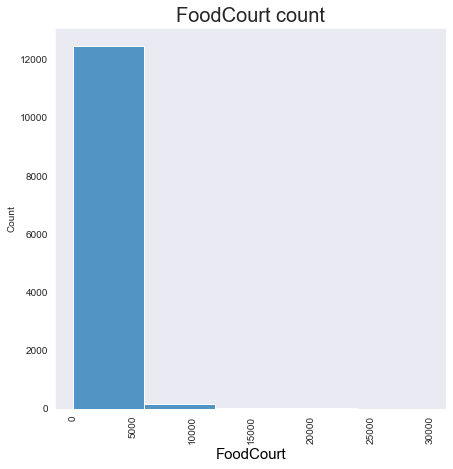

In [14]:
f, ax1 = plt.subplots(figsize=(7, 7))
sns.histplot(x='FoodCourt', data=all_data, bins=5)
plt.xlabel('FoodCourt', fontsize=15, color='black')
plt.title('FoodCourt count', fontsize=20)
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [15]:
for col in list(num_cols.keys()):
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [16]:
all_data['Total'] = 0
for col in list(num_cols.keys()):
    all_data['Total'] = all_data['Total'] + all_data[col]

<h4>Label Encoding</h4>

In [17]:
categorical_col = []
for col in all_data.columns:
    if all_data[col].dtype in [object, bool] and len(all_data[col].unique()) <= 100:
        categorical_col.append(col)

In [18]:
for col in categorical_col:
    all_data[col] = all_data[col].astype('category').cat.codes

In [19]:
ohe = OneHotEncoder(categories='auto')
array_hot_encoded = ohe.fit_transform(all_data[categorical_col]).toarray()
data_hot_encoded = pd.DataFrame(array_hot_encoded, index=all_data.index)
data_other_cols = all_data.drop(columns=categorical_col)
all_data = pd.concat([data_hot_encoded, data_other_cols], axis=1)

In [20]:
train_data = all_data[:size_train_df].copy()
test_data = all_data[size_train_df:]
train_data['Transported'] = y_train

In [21]:
train_data['Transported'] = train_data['Transported'].astype('category').cat.codes

In [22]:
clf = LocalOutlierFactor(contamination=0.025)
outliers = clf.fit_predict(train_data)
train_data_cleaned = train_data[np.where(outliers == 1, True, False)]
train_data_cleaned.shape

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


(8475, 29)

<AxesSubplot:xlabel='Transported', ylabel='count'>

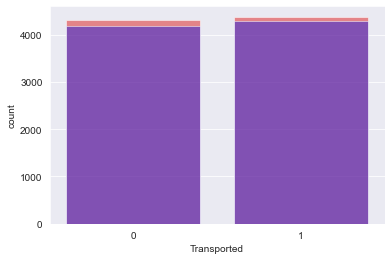

In [23]:
sns.countplot(x = train_data['Transported'], label='Original', color='red', alpha=0.5)
sns.countplot(x = train_data_cleaned['Transported'], label='Modified', color='blue', alpha=0.5)

In [24]:
X_train = train_data_cleaned.drop('Transported', axis=1)
y_train = train_data_cleaned['Transported']

In [25]:
X_train['Cabin_1'] = X_train['Cabin_1'].astype('int16')

1    4286
0    4189
Name: Transported, dtype: int64
0    4286
1    4286
Name: Transported, dtype: int64


C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


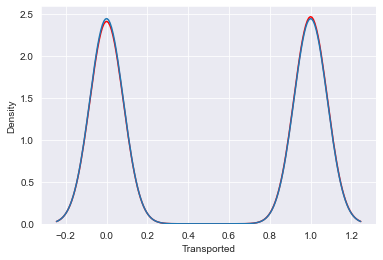

In [26]:
smote = SMOTE()
print(y_train.value_counts())
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(y_resampled.value_counts())

sns.kdeplot(y_train, label='Original', color='red')
sns.kdeplot(y_resampled, label='Modified')
X_train = X_resampled
y_train = y_resampled

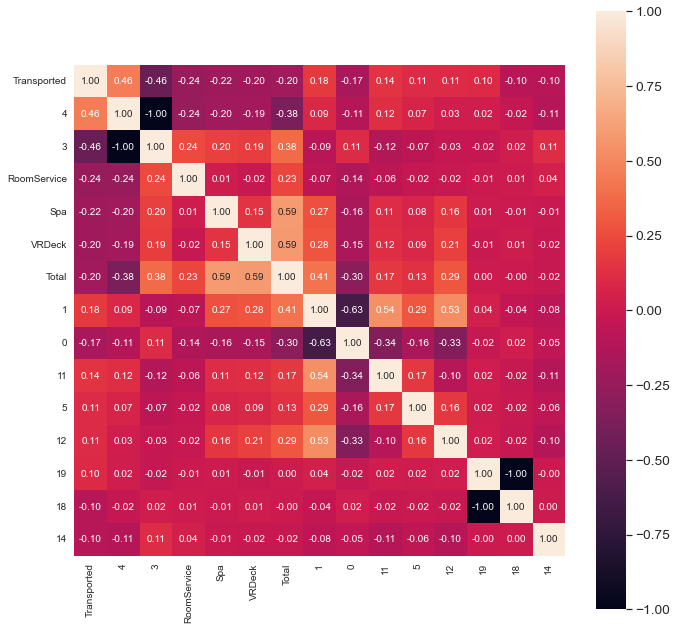

Index([4, 3, 'RoomService', 'Spa', 'VRDeck', 'Total', 1, 0, 11, 5, 12, 19, 18,
       14],
      dtype='object')

In [27]:
k = 15
f, ax = plt.subplots(figsize=(11, 11))
cols = train_data.corr().abs().nlargest(k, 'Transported')['Transported'].index
cm = np.corrcoef(train_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
cols = cols.drop('Transported')
cols

In [28]:
X_train = X_train[cols]

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


<Figure size 7200x2880 with 0 Axes>

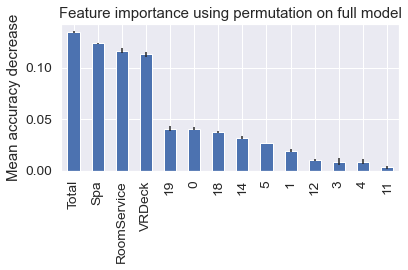

In [29]:
from sklearn.inspection import permutation_importance
import time

forest = RandomForestClassifier()
forest.fit(X_train, y_train)
feature_names = X_train.columns

start_time = time.time()
result = permutation_importance(forest, X_train, y_train, n_repeats=10, n_jobs=-1)
elapsed_time = time.time() - start_time

forest_importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(100, 40))
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importance using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show();

In [30]:
pipeline_df = Pipeline([('GaussianNB', GaussianNB())])
pipeline_knn = Pipeline([('KNeighborsClassifier', KNeighborsClassifier())])
pipeline_rf = Pipeline([('RandomForestClassifier', RandomForestClassifier())])
pipeline_lr = Pipeline([('LogisticRegression', LogisticRegression())])
pipeline_lgbm = Pipeline([('LightGBM', lgbm.LGBMClassifier())])
pipeline_svm = Pipeline([('SVC', SVC())])
pipeline_cb = Pipeline([('CatBoost', cb.CatBoostClassifier())])
pipeline_xgb = Pipeline([('XGBoost', xgb.XGBClassifier())])

pipelines = [pipeline_df, pipeline_knn, pipeline_rf, pipeline_lr, pipeline_lgbm, pipeline_svm, pipeline_cb, pipeline_xgb]
pipe_dict = {0: 'GaussianNB',
             1: 'KNeighborsClassifier',
             2: 'RandomForestClassifier',
             3: 'LogisticRegression',
             4: 'LightGBM',
             5: 'SVC',
             6: 'CatBoost',
             7: 'XGBoost'}

In [31]:
original_results = dict()
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train.values, y_train.values.ravel(), cv=4, scoring='accuracy').mean()
    original_results[pipe_dict[i]] = cv_score

C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Alex2\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Learning rate set to 0.022804
0:	learn: 0.6827222	total: 155ms	remaining: 2m 35s
1:	learn: 0.6731080	total: 159ms	remaining: 1m 19s
2:	learn: 0.6630813	total: 162ms	remaining: 54s
3:	learn: 0.6530838	total: 165ms	remaining: 41.2s
4:	learn: 0.6422815	total: 169ms	remaining: 33.6s
5:	learn: 0.6326874	total: 172ms	remaining: 28.5s
6:	learn: 0.6247912	total: 175ms	remaining: 24.9s
7:	learn: 0.6170998	total: 178ms	remaining: 22.1s
8:	learn: 0.6088625	total: 182ms	remaining: 20s
9:	learn: 0.6019754	total: 184ms	remaining: 18.3s
10:	learn: 0.5953683	total: 187ms	remaining: 16.9s
11:	learn: 0.5874441	total: 190ms	remaining: 15.7s
12:	learn: 0.5812488	total: 193ms	remaining: 14.7s
13:	learn: 0.5753086	total: 197ms	remaining: 13.8s
14:	learn: 0.5708024	total: 201ms	remaining: 13.2s
15:	learn: 0.5643721	total: 204ms	remaining: 12.6s
16:	learn: 0.5596032	total: 209ms	remaining: 12.1s
17:	learn: 0.5546480	total: 213ms	remaining: 11.6s
18:	learn: 0.5505554	total: 227ms	remaining: 11.7s
19:	learn: 0.

In [32]:
for key, value in sorted(original_results.items(), key=lambda item: item[1]):
    print(key, value)

GaussianNB 0.7397340177321512
KNeighborsClassifier 0.762832477834811
LogisticRegression 0.787564162389174
SVC 0.7879141390573962
RandomForestClassifier 0.7889640690620625
XGBoost 0.8002799813345777
LightGBM 0.8033131124591694
CatBoost 0.8086794213719085


In [33]:
x_train, x_test, Y_train, y_test = train_test_split(X_train, y_train, test_size=0.4)

In [34]:
def objective_lgbm(trial, data, target):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 4.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 4.0),
        'num_leaves': trial.suggest_int('num_leaves', 11, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 2000, 8000),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 0.5),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.8, 1),
        'cat_smooth' : trial.suggest_int('cat_smooth', 10, 100),
        'cat_l2': trial.suggest_int('cat_l2', 1, 20),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 200),
        'cat_feature' : trial.suggest_int('cat_feature', 10, 70),
        'n_jobs' : -1,
        'random_state': 42,
        'boosting_type': 'gbdt',
        'metric': 'AUC',
    }
    model = lgbm.LGBMClassifier(**params)
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],eval_metric='auc', early_stopping_rounds=300, verbose=False)
    preds = model.predict_proba(test_x)[:,1]
    auc = roc_auc_score(test_y, preds)

    return auc

In [ ]:
study_lgbm = optuna.create_study(direction="maximize")
func = lambda trial: objective_lgbm(trial, X_train, y_train)
study_lgbm.optimize(func, n_trials=1000)

In [53]:
dtrain = lgbm.Dataset(x_train, label=Y_train)
clf = lgbm.LGBMClassifier(reg_alpha=0.12943355019938285, reg_lambda=3.8664762450630366, boosting_type='gbdt', n_estimators=7996, learning_rate=0.036796791344551716, num_leaves=23, max_depth=50,                         min_data_in_leaf=15, lambda_l1=40, lambda_l2=41, min_child_samples=47, colsample_bytree=0.2609953562428016,
                          min_gain_to_split=0.0018347583782561926, bagging_fraction=0.4873035332070806, bagging_freq=1, feature_fraction=0.9389213024414161, cat_smooth=15, cat_l2=16,min_data_per_group=152, cat_feature=68)
model_lgbm = clf.fit(x_train, Y_train)
roc_auc_score(y_test, model_lgbm.predict(x_test))

[LightGBM] [Warning] feature_fraction is set=0.9389213024414161, colsample_bytree=0.2609953562428016 will be ignored. Current value: feature_fraction=0.9389213024414161
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=47 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_gain_to_split is set=0.0018347583782561926, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0018347583782561926
[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.12943355019938285 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] bagging_fraction is set=0.4873035332070806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4873035332070806
[LightGBM] [Warning] lambda_l2 is set=41, reg_lambda=3.8664762450630366 will be ignored. Current value: lambda_l2=41
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


0.7726776709336274

In [38]:
def objective_cb(trial, data=X_train, target=y_train):
    X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=42)

    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 10, 2000),
        'max_bin': trial.suggest_int('max_bin', 1, 400),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0001, 1.0, log = True),
        'subsample': trial.suggest_float('subsample', 0.1, 0.8),
        'random_seed': 42,
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
    }

    model = cb.CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set = [(X_val,y_val)], early_stopping_rounds = 222, verbose = False)
    y_pred = model.predict_proba(X_val)[:,1]
    roc_auc = roc_auc_score(y_val, y_pred)

    return roc_auc

[I 2022-10-13 02:52:53,694] A new study created in memory with name: no-name-a5b0f28f-670f-4265-8373-d31ab12d2937
[I 2022-10-13 02:52:56,084] Trial 0 finished with value: 0.8910947576861248 and parameters: {'max_depth': 7, 'learning_rate': 0.005383284814886508, 'n_estimators': 582, 'max_bin': 226, 'min_data_in_leaf': 78, 'l2_leaf_reg': 0.000361026356614728, 'subsample': 0.6440959264447489}. Best is trial 0 with value: 0.8910947576861248.
[I 2022-10-13 02:53:10,153] Trial 1 finished with value: 0.8881251649018205 and parameters: {'max_depth': 11, 'learning_rate': 0.06356321641700548, 'n_estimators': 1477, 'max_bin': 396, 'min_data_in_leaf': 242, 'l2_leaf_reg': 0.00019171970015903172, 'subsample': 0.5470460443501112}. Best is trial 0 with value: 0.8910947576861248.
[I 2022-10-13 02:53:12,840] Trial 2 finished with value: 0.8922181300881562 and parameters: {'max_depth': 11, 'learning_rate': 0.07408042375333232, 'n_estimators': 51, 'max_bin': 396, 'min_data_in_leaf': 133, 'l2_leaf_reg': 0.

Best value: 0.9044521451516825


In [39]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective_cb, n_trials = 1000)
print('Best value:', study.best_value)

0.9044521451516825

In [47]:
study.best_value

{'max_depth': 5,
 'learning_rate': 0.0695645670028684,
 'n_estimators': 1601,
 'max_bin': 43,
 'min_data_in_leaf': 276,
 'l2_leaf_reg': 0.06274989395366384,
 'subsample': 0.4841087205844804}

In [48]:
clf = cb.CatBoostClassifier(max_depth=5, learning_rate=0.0695645670028684, n_estimators=1601, max_bin=43, min_data_in_leaf=276, l2_leaf_reg=0.06274989395366384, subsample=0.4841087205844804)
model = clf.fit(x_train, Y_train)
roc_auc_score(y_test, model.predict(x_test))

0:	learn: 0.6632642	total: 2ms	remaining: 3.21s
1:	learn: 0.6405303	total: 4.18ms	remaining: 3.34s
2:	learn: 0.6213583	total: 6.2ms	remaining: 3.3s
3:	learn: 0.5999496	total: 8.47ms	remaining: 3.38s
4:	learn: 0.5800805	total: 10.5ms	remaining: 3.36s
5:	learn: 0.5647818	total: 13.1ms	remaining: 3.48s
6:	learn: 0.5533155	total: 15.6ms	remaining: 3.55s
7:	learn: 0.5407310	total: 17.8ms	remaining: 3.55s
8:	learn: 0.5304933	total: 20ms	remaining: 3.54s
9:	learn: 0.5211033	total: 22.3ms	remaining: 3.55s
10:	learn: 0.5123998	total: 24.4ms	remaining: 3.53s
11:	learn: 0.5052151	total: 26.7ms	remaining: 3.53s
12:	learn: 0.4974335	total: 28.5ms	remaining: 3.48s
13:	learn: 0.4912084	total: 30.7ms	remaining: 3.48s
14:	learn: 0.4875566	total: 32.9ms	remaining: 3.48s
15:	learn: 0.4796200	total: 35ms	remaining: 3.46s
16:	learn: 0.4762161	total: 37ms	remaining: 3.45s
17:	learn: 0.4718248	total: 39.7ms	remaining: 3.49s
18:	learn: 0.4680844	total: 42.1ms	remaining: 3.5s
19:	learn: 0.4646134	total: 44.4ms

0.7879346072967068

In [56]:
predictions = model.predict(test_data[cols].values)

In [57]:
sub = pd.DataFrame()
sub['PassengerId'] = test_IDs
sub['Transported'] = predictions
sub['Transported'] = sub['Transported'].apply(lambda x: False if x == 0 else True)
sub.to_csv('submission.csv', index=False)